In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("output.csv", sep=",",
                   header=0, #unnecessary
                   names=["Year",
                          "Tag",
                          "Province",
                          "Type",
                          "Size",
                          "Culture",
                          "Religion"                         
                         ])

In [6]:
data

,Year,Tag,Province,Type,Size,Culture,Religion
0,1840,RUS,New Arkhangelsk,aristocrats,15,alaskan,protestant
1,1840,RUS,New Arkhangelsk,aristocrats,5,alaskan,orthodox
2,1840,RUS,New Arkhangelsk,aristocrats,50,native_american_minor,animist
3,1840,RUS,New Arkhangelsk,aristocrats,50,inuit,animist
4,1840,RUS,New Arkhangelsk,artisans,32,alaskan,protestant
...,...,...,...,...,...,...,...
589667,1905,RUS,Усогорск,clergymen,34,russian,orthodox
589668,1905,RUS,Усогорск,craftsmen,794,russian,orthodox
589669,1905,RUS,Усогорск,craftsmen,130,ugrian,orthodox
589670,1905,RUS,Усогорск,labourers,5406,russian,orthodox


# Culture growth

## Culture total population per year

In [187]:
data.groupby(["Year", "Culture"], as_index=False).sum("Size").sort_values(by=["Year", "Size"], ascending=[True, False])

,Year,Culture,Size
31,1836,beifaren,45641720
153,1836,nanfaren,37317623
182,1836,russian,7647858
95,1836,japanese,7164368
33,1836,bengali,6903017
...,...,...,...
4958,1935,cherokee,5048
5087,1935,pueblo,3261
5093,1935,sami,2943
5101,1935,siberian,1405


## Start/end of observation

In [188]:
data["Year"].max()

1935

In [189]:
data["Year"].min()

1836

## Filtering

In [190]:
data[ (data["Year"] == data["Year"].max()) | (data["Year"] == data["Year"].min()) ]

,Year,Tag,Province,Type,Size,Culture,Religion
165253,1935,USA,Sitka,aristocrats,25,japanese,shinto
165254,1935,USA,Sitka,aristocrats,36,polish,catholic
165255,1935,USA,Sitka,artisans,216,alaskan,protestant
165256,1935,USA,Sitka,artisans,865,texan,protestant
165257,1935,USA,Sitka,bureaucrats,5228,texan,protestant
...,...,...,...,...,...,...,...
254667,1836,NaN,Alty-Kuduk,aristocrats,100,kazak,sunni
254668,1836,NaN,Alty-Kuduk,artisans,350,kazak,sunni
254669,1836,NaN,Alty-Kuduk,clergymen,50,kazak,sunni
254670,1836,NaN,Alty-Kuduk,farmers,6425,kazak,sunni


In [191]:
culture_df = data[ (data["Year"] == data["Year"].max()) | (data["Year"] == data["Year"].min()) ].groupby(["Year", "Culture"]).sum("Size").reset_index()

In [192]:
culture_df

,Year,Culture,Size
0,1836,aborigine,70346
1,1836,afar,21977
2,1836,afro_american,618131
3,1836,afro_antillean,183081
4,1836,afro_brazilian,687152
...,...,...,...
486,1935,yi,554256
487,1935,yoruba,3033234
488,1935,yue,5198898
489,1935,zhuang,1672923


## Population for end/start years

In [193]:
end = culture_df[ culture_df["Year"] == culture_df["Year"].max()].reset_index()[["Culture", "Size"]]

In [194]:
start = culture_df[ culture_df["Year"] == culture_df["Year"].min()][["Culture", "Size"]]

## Extinct culture

                There is additional row at the start.
                That means that some culture got extinct. Let's find it

In [195]:
merged = pd.merge(start[["Culture"]], end[["Culture"]],
                  how="outer",
                  indicator=True # _merge col values: right_only / left_only - data in one of the DataFrames,
                                 # both - obvious
                 )

In [196]:
merged

,Culture,_merge
0,aborigine,both
1,afar,both
2,afro_american,both
3,afro_antillean,both
4,afro_brazilian,both
...,...,...
241,yi,both
242,yoruba,both
243,yue,both
244,zhuang,both


In [197]:
extinct_culture = merged[merged["_merge"] != "both"].Culture.values[0]

In [198]:
extinct_culture

'tupinamba'

In [199]:
ext_date = data[ data["Culture"] == extinct_culture]["Year"].max()

In [200]:
print(f"{extinct_culture} died out between {ext_date} and {ext_date+5}")

tupinamba died out between 1880 and 1885


## Difference (times)

In [201]:
start_population = culture_df[ culture_df["Year"] == culture_df["Year"].min()][['Culture', 'Size']]

In [202]:
end_population = culture_df[ culture_df["Year"] == culture_df["Year"].max()].reset_index()[['Culture', 'Size']]

                                Missing value

In [203]:
ext = pd.DataFrame( {"Culture": extinct_culture, "Size": 0},
                    index=[
                           (start_population.loc[start_population["Culture"] == extinct_culture]
                            .index - 0.5).values[0]
                          ] 
                  )

In [204]:
end_population = pd.concat([end_population, ext], ignore_index=False)
end_population = end_population.sort_index().reset_index(drop=True)

                                Result

In [205]:
population_difference =\
   pd.DataFrame( [start_population.Culture,
                 ((end_population.Size - start_population.Size) / start_population.Size)
                 ] ).T

In [206]:
population_difference.sort_values(by="Size", ascending=False).head(5)

,Culture,Size
20,australian,526.804728
215,texan,94.565828
74,french_canadian,36.647948
133,manchu,8.547185
199,south_andean,7.824232


# The most diverse province

                                          Number of cultures in each province each year

In [207]:
cultures_count = data.groupby(["Year", "Province"])["Culture"].\
nunique().\
reset_index()

In [208]:
cultures_count

,Year,Province,Culture
0,1836,Abakan,2
1,1836,Aconcagua,1
2,1836,Ahuriri,2
3,1836,Aixa-aibes,2
4,1836,Ak-Mechet,2
...,...,...,...
56250,1935,Яссы,4
56251,1935,Ясудж,4
56252,1935,Яунде,4
56253,1935,Яффа,3


                                                Result

In [209]:
cultures_count.\
            loc[cultures_count.groupby("Year")["Culture"].idxmax()]

,Year,Province,Culture
2144,1836,Стамбул,8
3396,1840,Вад-Мадани,9
5535,1845,La Mesilla,12
8214,1850,La Mesilla,13
12527,1855,Парана,13
15206,1860,Парана,17
17688,1865,Монтевидео,19
20182,1870,Лос-Анджелес,18
23048,1875,Монтевидео,20
26032,1880,Пуэрто-Мальдонадо,23


# Population chart

In [7]:
cult1 = "alaskan"
cult2 = "cherokee"

In [8]:
def cult_history(data: pd.DataFrame, cult: "string") -> pd.Series:
    return data[ data["Culture"] == cult ].\
            groupby(["Year"], as_index=False).\
            sum("Size").\
            sort_values(by=["Year"], ascending=True)["Size"]

In [9]:
cult1_history, cult2_history = [cult_history(data, cult1), cult_history(data, cult2)]

In [10]:
cult1_history

0      596
1      618
2      715
3      929
4     1335
5     1717
6     2049
7     2666
8     3133
9     3143
10    3147
11    3348
12    3452
13    3488
14    3819
15    3430
16    2220
17    1526
18     940
19     882
20    1011
Name: Size, dtype: int64

In [11]:
cult2_history

0     7071
1     4500
2     2901
3     1963
4     1389
5      914
6      616
7      523
8      401
9      294
10     185
11     175
12     208
13     482
14     970
15    1451
16    1933
17    2590
18    3058
19    4057
20    5048
Name: Size, dtype: int64

In [12]:
years = sorted(list(data["Year"].unique()))

In [13]:
years

[1836,
 1840,
 1845,
 1850,
 1855,
 1860,
 1865,
 1870,
 1875,
 1880,
 1885,
 1890,
 1895,
 1900,
 1905,
 1910,
 1915,
 1920,
 1925,
 1930,
 1935]

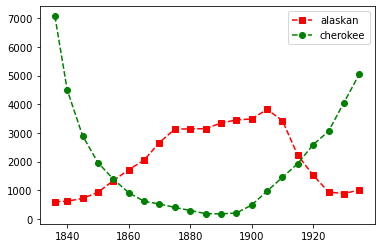

In [15]:
plt.plot(years, cult1_history.values, 'rs--',
         years, cult2_history.values, 'go--')

plt.legend([cult1, cult2], loc="upper right" )

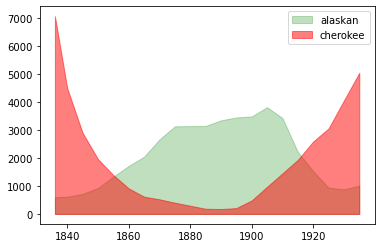

In [224]:
plt.fill_between( years, cult1_history, alpha=0.25, color="green" )
plt.fill_between( years, cult2_history, alpha=0.5, color="red"  )

plt.legend([cult1, cult2])

# Costa Rica population

In [226]:
cos_data = data[ data["Tag"] == "COS"].groupby(by=["Year"], as_index=False).sum("Size")

In [227]:
cos_data

,Year,Size
0,1836,22077
1,1840,22618
2,1845,23272
3,1850,24090
4,1855,24960
5,1860,25856
6,1865,27268
7,1870,28614
8,1875,30289
9,1880,32075


Text(1900, 90000, 'mass migration')

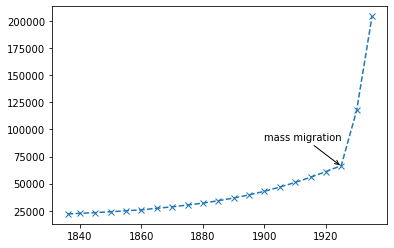

In [228]:
plt.plot( cos_data.Year.values, cos_data.Size.values, 'x--')

plt.annotate("mass migration", # text
             xy=(1925, 66000), # end of arrow
             xytext=(1900, 90000), # start of arrow
             arrowprops=dict(arrowstyle='->'))